In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

from preprocess import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_mode = 'train'

In [2]:
tickers = '5871.TW' # '5871.TW'
start = '1999-01-01'
end = '2024-02-06'
C = yf.Ticker(tickers)

# get and clean data
prc = fetch_price(C, start)
prc = pct_change(prc)
prc = clean(prc)

# Train test
window_size = 100
df_train, df_test = train_test(prc, window_size)

# Scaler
scaler = StandardScaler()
df_train = scaling(df_train)
df_test = scaling(df_test)

max(df_train.index), min(df_test.index)

/home/jacob/anaconda3/envs/mlntu/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/home/jacob/projects/RL_Stock/preprocess.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['do', 'dh', 'dl', 'dc', 'dv']] \
/home/jacob/projects/RL_Stock/preprocess.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

(Timestamp('2023-12-29 00:00:00+0800', tz='Asia/Taipei'),
 Timestamp('2023-08-10 00:00:00+0800', tz='Asia/Taipei'))

In [3]:
# train data
x, y, date = window_x_y(df_train, window_size)
X = process_x(x)
x_train, x_valid, y_train, y_valid = train_valid(X, y)
dataloader_train, dataloader_valid = \
        loader(x_train, y_train, batch_size=64), loader(x_valid, y_valid, batch_size=64)

x_test, y_test, date_test = window_x_y(df_test, window_size)
if data_mode == 'test':
        X_test = process_x(x_test)
        dataloader_test = loader(X_test, y_test, 64)

  0%|          | 0/2832 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:00<00:00, 676.88it/s]


In [4]:
max(date), min(date_test)

(Timestamp('2023-12-29 00:00:00+0800', tz='Asia/Taipei'),
 Timestamp('2024-01-02 00:00:00+0800', tz='Asia/Taipei'))

# RL - PPO

- Policy gradient and PPO [Colab Example](https://colab.research.google.com/drive/11NS001dD653xCsxypBCohnvsI-CKs64o#scrollTo=GfJIvML-RYjL)
- Different from game play PPO and stock:
    1. Inifinite, but regard as finite
    2. Action to not affect state, assuming the trading amount is not large
- Experiment: with Short
- Method
    1. 1 Stock
    2. Multi stock and predict 1
- TODO
    1. batch norm resnet
    1. add copnstraint
    1. Update observe
    2. Multi stock
- 問題:
    - Observe model and learn model 不能差太遠。現在初始化只有observe model
        - 解決方法：train learn network. Or do sample: 複習李弘毅的為甚麼observe model and learn model不能差太遠
    - Have not add fee

In [5]:
import copy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.distributions import Categorical
class PolicyGradientNetwork(nn.Module):

    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1600)
        self.fc2 = nn.Linear(1600, 16)
        self.fc3 = nn.Linear(16, num_classes)
        
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, state):
        state = torch.flatten(state, 1)
        hid = torch.tanh(self.fc1(state))
        self.dropout1(hid)
        hid = torch.tanh(self.fc2(hid))
        self.dropout2(hid)
        return F.softmax(self.fc3(hid), dim=-1)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(5, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.softmax(x, dim=-1) # torch.tanh(x)

In [6]:
class PolicyGradientAgent():
    
    def __init__(self, network, observe_network):
        self.network = network
        self.observe_network = observe_network
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.000001) # fcnet: lr=0.000001
        self.observe_optimizer = optim.Adam(self.observe_network.parameters(), lr=0.000001)
        
    def forward(self, state):
        return self.network(state)
    
    def learn(self, state, action, reward, p_observe, beta = .001):
        """
        state and reward for 1 episode
        action: [-1, 0, 1]
        model output prob: [action -1, action 0, action 1]
        """
        """
        Q:
        1. use prob_train or prob_observe in loss
        """
        # Train network
        self.network.train()
        p_train = self.network(state)
        # Probability with action from observe network
        probs_train = p_train[torch.arange(p_train.size(0)), action.long() + 1]
        # action to [-1, 0, 1] if actions number = 3
        action_train = torch.argmax(p_train, dim=1)
        if p_train.shape[1] == 3:
            action_train -= 1
        # Observe network
        loss = (-torch.log(probs_train) * reward).sum() # You don't need to revise this to pass simple baseline (but you can)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item(), action_train
    
    def learn_observe(self, state, action, reward):
        """
        If train seperately lead error
        'Trying to backward through the graph a second time 
        (or directly access saved tensors after they have already been freed). 
        Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). 
        Specify retain_graph=True if you need to backward through the graph a second time or 
        if you need to access saved tensors after calling backward'
        """
        # Train network
        self.observe_network = copy.deepcopy(self.network)
    
    def sample(self, dataloader_train, type):
        states, rewards, actions, returns, p_observes = [], [], [], [], []
        # x is state
        with torch.no_grad():
            for x, y in tqdm(dataloader_train):
                # print(episode)
                # for each batch look as a "trajectory", or "episode"
                # return action, log_prob in a episode
                if type == "observe":
                    p = self.observe_network(x)
                elif type == "learn":
                    p = self.network(x)
                    
                action = torch.where(y > 0, torch.tensor(1.), torch.tensor(-1.))
                reward = torch.mul(y.reshape(-1), action.to(dtype = torch.float32))
                states.append(x)
                returns.append(y)
                actions.append(action.reshape(-1))
                rewards.append(reward.detach())
                p_observes.append(p.detach())
        return states, rewards, actions, returns, p_observes
    
    def validate(self, state):
        with torch.no_grad():
            self.network.eval()
            p = self.network(state)
            action = torch.argmax(p, dim=1) 
            if p.shape[1] == 3:
                action -= 1
        return action

In [7]:
# Init model neutral
# resnet: train
# -- Observe model: Y
# -- Learn model: N
# fcnet: try init
# -- Observe model: Y
# -- Learn model: N
import copy, math
def train_neutral(agent, dataloader_train):
           
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(agent.observe_network.parameters(), lr=0.01)
    
    while True:
        pos_rate = []
        neg_rate = []
        for state, y in dataloader_train:
            # Train observe model
            agent.observe_network.train() # Set model to training mode
            optimizer.zero_grad() # Zero the gradients
            outputs = agent.observe_network(state) # Forward pass
            labels = \
				torch.cat([torch.tensor([.4, .2, .4]).reshape(1, -1) for i in range(len(outputs))], dim = 0)
     
            loss = criterion(outputs, labels.to(device)) # Compute the loss
            loss.backward() # Backward pass
            optimizer.step() # Update model parameters
			
            pos_ = (torch.argmax(outputs, dim = 1) == 2).sum().item() / len(outputs)
            neg_ = (torch.argmax(outputs, dim = 1) == 0).sum().item() / len(outputs)
            pos_rate.append(pos_)
            neg_rate.append(neg_)
        
        pos_rate_mean = torch.tensor(pos_rate).mean()
        neg_rate_mean = torch.tensor(neg_rate).mean()
        print(pos_rate_mean, neg_rate_mean)
  
        # Get a "neutral model"
        if pos_rate_mean > 0.4 and neg_rate_mean > 0.4:
            break
        # Random init again since this is hard to train neutral
        if pos_rate_mean == 1 or neg_rate_mean == 1 or pos_rate_mean == 0 or neg_rate_mean == 0:
            return None
        
    return agent

def init_model(model_name, input_size, num_classes, dataloader_train):
    while True:
        torch.cuda.empty_cache()
        # Define model
        print('Try model')
        if model_name == 'resnet':
            network_collect_data = ResNet(BasicBlock, [3, 4, 6, 3], num_classes).to(device)
            network_learn = ResNet(BasicBlock, [3, 4, 6, 3], num_classes).to(device)
        elif model_name == 'fcnet':
            network_collect_data = PolicyGradientNetwork(input_size, num_classes).to(device)
            network_learn = PolicyGradientNetwork(input_size, num_classes).to(device)
        agent = PolicyGradientAgent(network_learn, network_collect_data)
        
        states, rewards, actions, returns, log_probs_observes = agent.sample(dataloader_train, "learn")
        actions = torch.cat(actions)
        
        # fcnet 初始化比較容易，多嘗試幾次就可以
        if model_name == 'fcnet':
            print((actions < 0).sum()/len(actions), (actions > 0).sum()/len(actions))
            if (actions < 0).sum()/len(actions) > 0.3 and (actions > 0).sum()/len(actions) > 0.3:
                break
        # resnet 初始化太難找到中立的，都是很多Long或很多Short，所以用訓練的
        if model_name == 'resnet':
            agent = train_neutral(agent, dataloader_train)
            if agent is not None:
                break
            else:
                continue
			
    torch.cuda.empty_cache()
    return agent

# init_model(model_name, input_size, num_classes, dataloader_train)

In [ ]:
""""""""""""""""""""""""
### settings ###
# Models
model_names = ['resnet', 'fcnet']
model_name = model_names[0]
# Create agents
num_classes = 3
# Method
method = "PPO"
# Set
epoch = 1000
beta = .00001
""""""""""""""""""""""""
# Short 
if num_classes == 2:
    short = ""
elif num_classes == 3:  
    short = "_short"
# Input size
for x, y in dataloader_train:
    input_size = torch.flatten(x, 1).shape[1]
# Define model
agent = init_model(model_name, input_size, num_classes, dataloader_train)

# Make dir
new_directory = f"result/{method}/{model_name}"
if not os.path.exists(new_directory):
    os.makedirs(new_directory)
    
# Collect data (experience)
"""
For states, rewards, and actions:
[states_for_episodes_1, states_for_episodes_2, ...]
[rewards_for_episodes_1, rewards_for_episodes_2, ...]
[actions_for_episodes_1, actions_for_episodes_2, ...]
"""
states, rewards, actions, returns, p_observes = agent.sample(dataloader_train, "learn")
print(f'Total {len(states)} episodes')

# Store init model
torch.save(agent.network, f'temp/temp.pth')

# train
import pickle
import numpy as np
loss_train = []
returns_train = []
returns_val = []
max_val_rewards = -1000000
last_train_loss = 10000
adj_fact_pos, adj_fact_neg = 1, 1
for e in range(epoch):
    # loss train and rewards train for the epcoh
    loss_train_epoch = 0
    rewards_train_epoch = 0
    action_pos_list, action_neg_list = [], []
    
    # Train process
    for episode, (state, action, reward, return_, p_observe) in \
        enumerate(zip(states, actions, rewards, returns, p_observes)):
        """
        reward: reward from experience of another network
        return_: real close - open, as real rewards, not rewards after actions
        print(len(state), len(action), len(reward), len(return_))
        """
        # Adjust rewards
        reward = torch.where(reward > 0, reward * adj_fact_pos, reward)
        reward = torch.where(reward < 0, reward * adj_fact_neg, reward)
        
        # learn
        loss, action_train = agent.learn(state, action, reward, p_observe, beta)    
        loss_train_epoch += loss
        
        # print(action_train)
        action_pos_ratio = torch.sum(action_train > 0)/len(action_train)
        action_neg_ratio = torch.sum(action_train < 0)/len(action_train)
        action_pos_list.append(action_pos_ratio)
        action_neg_list.append(action_neg_ratio)
        
        
        # compute returns
        reward_train = torch.mul(return_.reshape(-1), action_train.to(dtype = torch.float32))
        rewards_train_epoch += reward_train.sum()
    
    # Add train result
    loss_train.append(loss_train_epoch/len(dataloader_train))
    returns_train.append(rewards_train_epoch.cpu()/len(dataloader_train))  
    ########
    # Adjust: Check loss, learn / update sample
    # -- fcnet: No
    # -- resnet: Y    
    # Update lr and check train loss    
    if math.isnan(loss):
        print('Loss too small, update sample')
        if model_name == 'resnet':
            states, rewards, actions, returns, p_observes = agent.sample(dataloader_train, "learn")
    else:
        torch.save(agent.network, f'temp/temp.pt')
        if agent.optimizer.param_groups[0]['lr'] < .01:
            agent.optimizer.param_groups[0]['lr'] *= 1.1            
    ########
    
    ########
    # action_pos_ratio
    action_pos_ratio = torch.tensor(action_pos_list).mean()
    action_neg_ratio = torch.tensor(action_neg_list).mean()    
    # Adjust: Update adj rewards
    # -- fcnet: No. fcnet Do not need this
    # -- resnet: Yes
    """
    if model_name == 'resnet':
        if action_pos_ratio < 0.2:
            adj_fact_pos *= 1.01
        elif action_pos_ratio > 0.7:
            adj_fact_pos *= 0.99 
        if action_neg_ratio < 0.2:   
            adj_fact_neg *= 1.01
        elif action_neg_ratio > 0.7:
            adj_fact_neg *= 0.99    
    """
    ########    
    
    # Valdiate
    rewards_val_epoch = 0
    for x, y in dataloader_valid:
        action_val = agent.validate(x)
        reward_val = torch.mul(y.reshape(-1), action_val.to(dtype = torch.float32))
        rewards_val_epoch += reward_val.sum()
    returns_val.append(rewards_val_epoch.detach().cpu()/len(dataloader_valid))
    
    print(f'epoch: {e} ========')
    print('action pos ratio:', action_pos_ratio)
    print('action neg ratio:', action_neg_ratio)
    print(f'train loss/rewards: {loss, rewards_train_epoch.item()/len(dataloader_train)}')
    print(f'val rewards: {rewards_val_epoch/len(dataloader_valid)}')
    # print('lr:', agent.optimizer.param_groups[0]['lr'])
    
    if rewards_val_epoch.detach().cpu() > max_val_rewards:
        max_val_rewards = rewards_val_epoch.detach().cpu()
        torch.save(agent.network, f'result/{method}/{model_name}/best_agent{short}.pt')
    if e % 100 == 0:
        torch.save(agent.network, f'result/{method}/{model_name}/agent_checkpoint_{e}{short}.pt')
        
    with open(f'result/{method}/{model_name}/returns_train_val{short}.pkl', 'wb') as f:
        pickle.dump((returns_train, returns_val, loss_train), f)
        

In [ ]:
action + 1

tensor([2., 2., 0., 2., 2., 2., 2., 0., 0., 0., 2., 0., 0., 0., 2., 2., 0., 2.,
        0., 0., 0., 2., 2., 0., 0., 2., 0., 2., 2., 2., 0., 0., 0., 0., 0., 2.,
        2., 0., 2., 0., 2., 0., 0., 0., 2., 2., 2., 0., 2., 2., 0., 0., 0., 0.,
        0., 0., 0., 2., 2., 2., 0., 2., 0., 2.], device='cuda:0')

In [ ]:
p_train = agent.network(state)
probs_train = p_train[torch.arange(p_train.size(0)), action + 1]
action = torch.argmax(p_train, dim=1)

In [ ]:
import torch

# Create a tensor of shape (10, 20) with random values
tensor1 = torch.rand(10, 20)

# Create a tensor of shape (10,) with random integers between 0 and 19
tensor2 = torch.randint(0, 20, (10,))

# Use tensor2 to select the first 1's column from tensor1
selected_tensor = tensor1[torch.arange(tensor1.size(0)), tensor2]

print(tensor1, tensor2, selected_tensor)


tensor([[0.7849, 0.4404, 0.7697, 0.6071, 0.7904, 0.9136, 0.6767, 0.3364, 0.8368,
         0.3853, 0.8152, 0.4801, 0.3574, 0.5533, 0.3222, 0.1207, 0.5904, 0.8830,
         0.7205, 0.7769],
        [0.3774, 0.9786, 0.4051, 0.9181, 0.9191, 0.1497, 0.9547, 0.8726, 0.9968,
         0.0165, 0.3539, 0.9274, 0.5373, 0.4431, 0.5350, 0.2954, 0.5423, 0.8999,
         0.4447, 0.9443],
        [0.3494, 0.7801, 0.8628, 0.9545, 0.5828, 0.2136, 0.9571, 0.7433, 0.1596,
         0.5017, 0.3940, 0.3168, 0.9572, 0.7108, 0.5210, 0.7764, 0.1023, 0.4016,
         0.3454, 0.1497],
        [0.5767, 0.1953, 0.2859, 0.2086, 0.3167, 0.0671, 0.2806, 0.9442, 0.9929,
         0.9634, 0.9246, 0.4612, 0.4656, 0.7769, 0.3811, 0.6171, 0.5631, 0.3634,
         0.9753, 0.6451],
        [0.4018, 0.2476, 0.2312, 0.6560, 0.8266, 0.5287, 0.1999, 0.2807, 0.5969,
         0.8101, 0.2701, 0.9352, 0.9052, 0.8634, 0.9122, 0.2003, 0.3911, 0.2432,
         0.9869, 0.8043],
        [0.9132, 0.9750, 0.6148, 0.1508, 0.8129, 0.4386, 0.5

In [ ]:
torch.arange(tensor1.size(0))

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
action_val, torch.cat(returns).sum()

(tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
         1, 1, 0, 0], device='cuda:0'),
 tensor(-0.1633, device='cuda:0'))

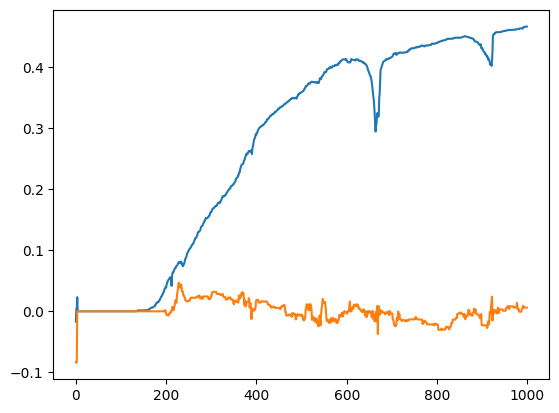

In [ ]:

plt.plot(returns_train)
plt.plot(returns_val)